# NSST-PAPCNN Image Fusion Model Evaluation

This notebook runs the NSST-PAPCNN (Non-Subsampled Shearlet Transform with Parameter-Adaptive Pulse Coupled Neural Network) image fusion model and saves the results to a dedicated folder. We'll use our virtual environment to ensure all dependencies are available.

In [16]:
# Import required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import glob
import sys
from tqdm import tqdm  # Using standard tqdm instead of tqdm.notebook
from scipy import ndimage
import pywt  # PyWavelets for wavelet transform operations

# For evaluation metrics
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Import our evaluation module
import fusion_evaluation as fe

# Check Python version
print(f"Python version: {sys.version}")

# Check if we're running in the virtual environment
import site
print(f"Using Python from: {sys.executable}")
print(f"Site packages: {site.getsitepackages()}")

Python version: 3.12.6 (tags/v3.12.6:a4a2d2b, Sep  6 2024, 20:11:23) [MSC v.1940 64 bit (AMD64)]
Using Python from: o:\Projects\image-fusion-zoom-main\fusion_env\Scripts\python.exe
Site packages: ['o:\\Projects\\image-fusion-zoom-main\\fusion_env', 'o:\\Projects\\image-fusion-zoom-main\\fusion_env\\Lib\\site-packages']


## Import NSST-PAPCNN Functions

First, let's import the key functions from our NSST-PAPCNN Image Fusion notebook.

In [17]:
# Set path to dataset
base_dataset_path = "Medical_Image_Fusion_Methods/Havard-Medical-Image-Fusion-Datasets"
modality_pair = "CT-MRI"  # Can be changed to PET-MRI or SPECT-MRI

def load_image_pair(img_path1, img_path2, resize=True, img_size=256):
    """
    Load a pair of medical images from different modalities
    
    Args:
        img_path1: Path to first image (e.g., CT)
        img_path2: Path to second image (e.g., MRI)
        resize: Whether to resize images
        img_size: Target size for resizing
        
    Returns:
        A tuple containing both images as numpy arrays
    """
    # Read images
    img1 = cv2.imread(img_path1, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img_path2, cv2.IMREAD_GRAYSCALE)
    
    # Check if images were loaded successfully
    if img1 is None or img2 is None:
        raise ValueError(f"Failed to load images: {img_path1} or {img_path2}")
    
    # Resize if needed
    if resize and (img1.shape[0] != img_size or img1.shape[1] != img_size):
        img1 = cv2.resize(img1, (img_size, img_size))
        img2 = cv2.resize(img2, (img_size, img_size))
    
    # Normalize to [0, 1]
    img1 = img1 / 255.0
    img2 = img2 / 255.0
    
    return img1, img2

def get_image_pairs(dataset_path, modality_pair, count=None):
    """
    Get paths to pairs of medical images
    
    Args:
        dataset_path: Base path to dataset
        modality_pair: Type of modality pair, e.g., 'CT-MRI', 'PET-MRI', 'SPECT-MRI'
        count: Number of pairs to return (None for all)
    
    Returns:
        List of tuples containing paths to image pairs
    """
    # Get full path to specific modality folder
    modality_path = os.path.join(dataset_path, modality_pair)
    
    # Split modality names
    modalities = modality_pair.split('-')
    mod1 = modalities[0]  # e.g., CT
    mod2 = modalities[1]  # e.g., MRI
    
    # Get paths to modality folders
    mod1_folder = os.path.join(modality_path, mod1)
    mod2_folder = os.path.join(modality_path, mod2)
    
    # Get lists of filenames for each modality
    mod1_files = sorted(os.listdir(mod1_folder))
    mod2_files = sorted(os.listdir(mod2_folder))
    
    # Find common filenames
    common_files = sorted(list(set(mod1_files).intersection(set(mod2_files))))
    
    if not common_files:
        print("No matching files found. Trying all files...")
        # If no exact matches, try to match by number
        all_pairs = []
        for file1 in mod1_files:
            if not file1.endswith('.png'):
                continue
            base_name = os.path.splitext(file1)[0]  # Get filename without extension
            for file2 in mod2_files:
                if file2.endswith('.png') and os.path.splitext(file2)[0] == base_name:
                    all_pairs.append((
                        os.path.join(mod1_folder, file1),
                        os.path.join(mod2_folder, file2)
                    ))
                    break
    else:
        # Create pairs with full paths
        all_pairs = [(os.path.join(mod1_folder, f), os.path.join(mod2_folder, f)) for f in common_files]
    
    # Limit number of pairs if specified
    if count is not None:
        all_pairs = all_pairs[:min(count, len(all_pairs))]
    
    return all_pairs

## Implement the NSST-PAPCNN Fusion Model

Now, let's implement the key components of the NSST-PAPCNN fusion model.

In [18]:
def nsst_decomposition(img, levels=4, wavelet='db1'):
    """
    Decompose image using wavelet transform as an approximation of NSST
    
    Args:
        img: Input image
        levels: Number of decomposition levels
        wavelet: Wavelet type
        
    Returns:
        Dictionary containing coefficients at each level and orientation
    """
    # Initialize result dictionary
    decomposition = {}
    
    # Perform stationary wavelet transform (undecimated - similar to non-subsampled transform)
    coeffs = pywt.swt2(img, wavelet, level=levels)
    
    # Extract coefficients
    decomposition['lowpass'] = coeffs[0][0]  # Approximation coefficients from the highest level
    
    # Store highpass coefficients for each level
    decomposition['highpass'] = []
    
    for i in range(levels):
        # Get horizontal, vertical and diagonal details
        level_coeffs = {
            'horizontal': coeffs[i][1][0],
            'vertical': coeffs[i][1][1],
            'diagonal': coeffs[i][1][2]
        }
        decomposition['highpass'].append(level_coeffs)
    
    return decomposition

def nsst_reconstruction(decomposition, wavelet='db1'):
    """
    Reconstruct image from wavelet coefficients
    
    Args:
        decomposition: Dictionary containing wavelet coefficients
        wavelet: Wavelet type
        
    Returns:
        Reconstructed image
    """
    # Get number of levels
    levels = len(decomposition['highpass'])
    
    # Prepare coefficients for reconstruction
    coeffs = []
    for i in range(levels):
        level_idx = levels - 1 - i
        if i == 0:
            # For the first level, use the lowpass coefficients
            cA = decomposition['lowpass']
        else:
            # For subsequent levels, approximate coefficients are already included
            cA = None
            
        # Get highpass coefficients
        level_highpass = decomposition['highpass'][level_idx]
        cH = level_highpass['horizontal']
        cV = level_highpass['vertical']
        cD = level_highpass['diagonal']
        
        # Combine coefficients
        if i == 0:
            coeffs.append((cA, (cH, cV, cD)))
        else:
            coeffs.append((None, (cH, cV, cD)))
    
    # Perform inverse stationary wavelet transform
    reconstructed = pywt.iswt2(coeffs, wavelet)
    
    return reconstructed

In [19]:
def calculate_spatial_frequency(img):
    """
    Calculate spatial frequency of an image
    
    Args:
        img: Input image
        
    Returns:
        Spatial frequency value
    """
    # Calculate row frequency
    rf = np.sqrt(np.sum(np.diff(img, axis=1) ** 2) / (img.shape[0] * img.shape[1]))
    
    # Calculate column frequency
    cf = np.sqrt(np.sum(np.diff(img, axis=0) ** 2) / (img.shape[0] * img.shape[1]))
    
    # Calculate spatial frequency
    sf = np.sqrt(rf ** 2 + cf ** 2)
    
    return sf

def calculate_weight_exponent(img):
    """
    Calculate weight exponent based on spatial frequency
    
    Args:
        img: Input image
        
    Returns:
        Weight exponent for PAPCNN
    """
    sf = calculate_spatial_frequency(img)
    # Based on the paper, weight exponent is inversely proportional to spatial frequency
    weight_exp = np.exp(-sf)
    return weight_exp

def papcnn_fusion(img1, img2, iterations=10):
    """
    Parameter-Adaptive Pulse Coupled Neural Network (PAPCNN) for image fusion
    
    Args:
        img1: First input image
        img2: Second input image
        iterations: Number of PAPCNN iterations
        
    Returns:
        Fusion weights for both images
    """
    # Calculate weight exponents based on spatial frequency
    beta1 = calculate_weight_exponent(img1)
    beta2 = calculate_weight_exponent(img2)
    
    # Get image dimensions
    h, w = img1.shape
    
    # Initialize PAPCNN variables
    # F: Feeding input
    F1 = img1.copy()
    F2 = img2.copy()
    
    # L: Linking
    L1 = np.zeros((h, w))
    L2 = np.zeros((h, w))
    
    # U: Internal activity
    U1 = F1
    U2 = F2
    
    # Y: Pulse output
    Y1 = np.zeros((h, w))
    Y2 = np.zeros((h, w))
    
    # T: Dynamic threshold
    T1 = np.ones((h, w))
    T2 = np.ones((h, w))
    
    # Linking strength and decay parameters
    alpha_L = 0.1
    alpha_T = 0.2
    V_T = 20.0
    
    # Kernel for linking
    kernel = np.array([[0.1, 0.1, 0.1], 
                      [0.1, 0.0, 0.1], 
                      [0.1, 0.1, 0.1]])
    
    # Output accumulation
    Y1_sum = np.zeros((h, w))
    Y2_sum = np.zeros((h, w))
    
    # Iterate PAPCNN
    for n in range(iterations):
        # Update linking
        L1 = alpha_L * L1 + ndimage.convolve(Y1, kernel, mode='constant')
        L2 = alpha_L * L2 + ndimage.convolve(Y2, kernel, mode='constant')
        
        # Update internal activity
        U1 = F1 * (1 + beta1 * L1)
        U2 = F2 * (1 + beta2 * L2)
        
        # Update pulse output
        Y1 = (U1 > T1).astype(np.float64)
        Y2 = (U2 > T2).astype(np.float64)
        
        # Update threshold
        T1 = alpha_T * T1 + V_T * Y1
        T2 = alpha_T * T2 + V_T * Y2
        
        # Accumulate output
        Y1_sum += Y1 * (n + 1)
        Y2_sum += Y2 * (n + 1)
    
    # Calculate fusion weights
    # Add small epsilon to avoid division by zero
    epsilon = 1e-10
    weight1 = Y1_sum / (Y1_sum + Y2_sum + epsilon)
    weight2 = Y2_sum / (Y1_sum + Y2_sum + epsilon)
    
    return weight1, weight2

In [20]:
def lowpass_fusion(lowpass1, lowpass2):
    """
    Fusion rule for low-frequency coefficients using average method
    
    Args:
        lowpass1: Low-frequency coefficients of first image
        lowpass2: Low-frequency coefficients of second image
        
    Returns:
        Fused low-frequency coefficients
    """
    # Simple average fusion for lowpass components
    return (lowpass1 + lowpass2) / 2

def highpass_fusion(highpass1, highpass2):
    """
    Fusion rule for high-frequency coefficients using PAPCNN
    
    Args:
        highpass1: High-frequency coefficients of first image
        highpass2: High-frequency coefficients of second image
        
    Returns:
        Fused high-frequency coefficients
    """
    # Apply PAPCNN to determine weights
    weight1, weight2 = papcnn_fusion(np.abs(highpass1), np.abs(highpass2))
    
    # Apply weighted fusion
    fused_highpass = weight1 * highpass1 + weight2 * highpass2
    
    return fused_highpass

def nsst_papcnn_fusion(img1, img2, levels=3, wavelet='db1'):
    """
    Complete NSST-PAPCNN fusion method
    
    Args:
        img1: First input image
        img2: Second input image
        levels: Number of decomposition levels
        wavelet: Wavelet type
        
    Returns:
        Fused image
    """
    # Decompose images
    decomp1 = nsst_decomposition(img1, levels, wavelet)
    decomp2 = nsst_decomposition(img2, levels, wavelet)
    
    # Initialize fused decomposition
    fused_decomp = {'lowpass': None, 'highpass': []}
    
    # Fuse lowpass coefficients
    fused_decomp['lowpass'] = lowpass_fusion(decomp1['lowpass'], decomp2['lowpass'])
    
    # Fuse highpass coefficients for each level
    for level in range(levels):
        level_fused = {}
        
        # Fuse each orientation (horizontal, vertical, diagonal)
        for orientation in ['horizontal', 'vertical', 'diagonal']:
            highpass1 = decomp1['highpass'][level][orientation]
            highpass2 = decomp2['highpass'][level][orientation]
            level_fused[orientation] = highpass_fusion(highpass1, highpass2)
        
        fused_decomp['highpass'].append(level_fused)
    
    # Reconstruct fused image
    fused_img = nsst_reconstruction(fused_decomp, wavelet)
    
    # Ensure pixel values are in valid range [0, 1]
    fused_img = np.clip(fused_img, 0, 1)
    
    return fused_img

## Get Dataset and Load Image Pairs

Now, let's get the image pairs from our dataset.

Found 184 image pairs for CT-MRI


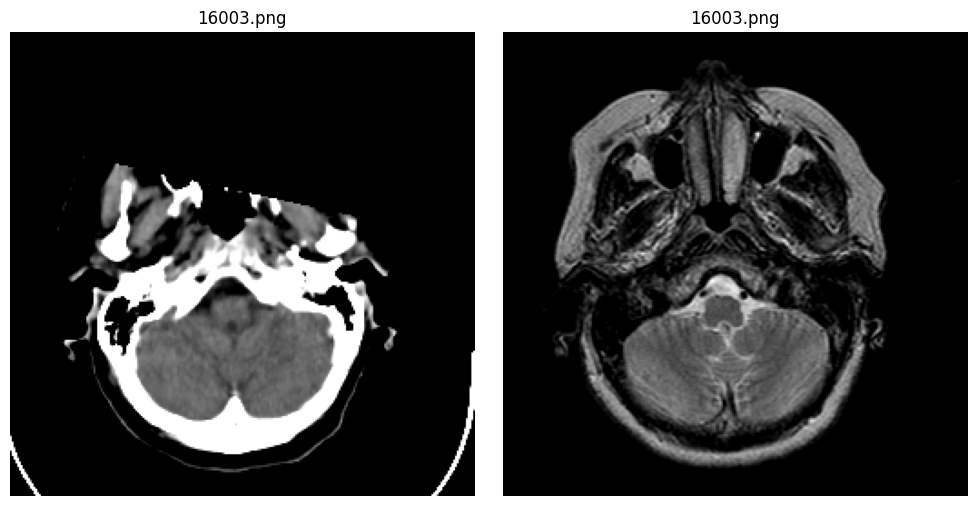

In [21]:
# Get all image pairs
image_pairs = get_image_pairs(base_dataset_path, modality_pair)
print(f"Found {len(image_pairs)} image pairs for {modality_pair}")

# Display a sample pair
if image_pairs:
    img1_path, img2_path = image_pairs[0]
    img1, img2 = load_image_pair(img1_path, img2_path)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img1, cmap='gray')
    plt.title(os.path.basename(img1_path))
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img2, cmap='gray')
    plt.title(os.path.basename(img2_path))
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No image pairs found. Please check the dataset path.")

## Process Image Pairs with NSST-PAPCNN Fusion

Now, let's apply the NSST-PAPCNN fusion to our image pairs and save the results.



Processing:   0%|          | 0/5 [00:00<?, ?it/s]

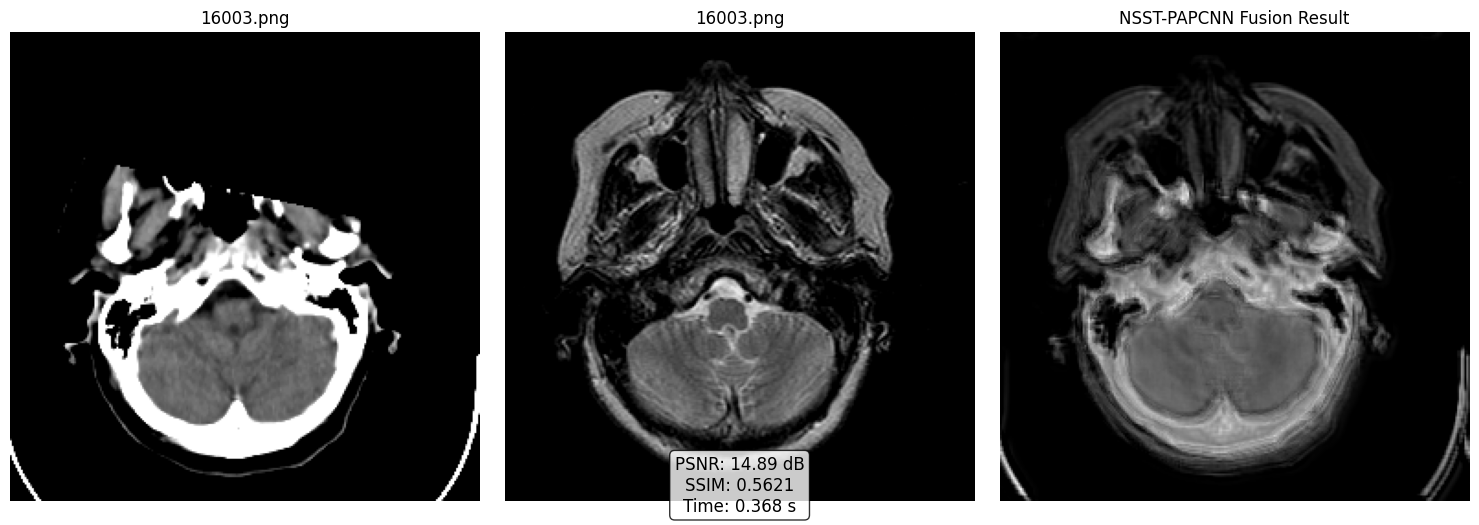








Processing: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Processed 5 image pairs
Average PSNR: 14.45 dB
Average SSIM: 0.5641
Average execution time: 0.410 seconds per image pair
Results saved to fused_images/NSST_PAPCNN/


In [22]:
# Set the number of image pairs to process (None for all)
max_pairs = 5

# Process image pairs
if image_pairs:
    # Limit the number of pairs if specified
    if max_pairs is not None:
        pairs_to_process = image_pairs[:min(max_pairs, len(image_pairs))]
    else:
        pairs_to_process = image_pairs
    
    # Initialize results storage
    results = []
    
    # Import tqdm directly instead of tqdm.notebook to avoid IProgress dependency
    from tqdm import tqdm as std_tqdm
    
    # Process each pair
    for idx, (img1_path, img2_path) in enumerate(std_tqdm(pairs_to_process, desc="Processing")):
        # Load images
        img1, img2 = load_image_pair(img1_path, img2_path)
        
        # Apply NSST-PAPCNN fusion
        start_time = time.time()
        fused_img = nsst_papcnn_fusion(img1, img2, levels=3, wavelet='db1')
        execution_time = time.time() - start_time
        
        # Save the result using our evaluation module
        output_path = fe.save_fusion_result(fused_img, img1_path, img2_path, "NSST_PAPCNN")
        
        # Calculate metrics
        metrics = fe.evaluate_fusion(fused_img, img1, img2)
        metrics['time'] = execution_time
        
        # Store results
        results.append({
            'img1': os.path.basename(img1_path),
            'img2': os.path.basename(img2_path),
            'output': output_path,
            **metrics
        })
        
        # Display the first result
        if idx == 0:
            plt.figure(figsize=(15, 5))
            
            # First input image
            plt.subplot(1, 3, 1)
            plt.imshow(img1, cmap='gray')
            plt.title(os.path.basename(img1_path))
            plt.axis('off')
            
            # Second input image
            plt.subplot(1, 3, 2)
            plt.imshow(img2, cmap='gray')
            plt.title(os.path.basename(img2_path))
            plt.axis('off')
            
            # Fused result
            plt.subplot(1, 3, 3)
            plt.imshow(fused_img, cmap='gray')
            plt.title('NSST-PAPCNN Fusion Result')
            plt.axis('off')
            
            # Add metrics as text
            metrics_text = (
                f"PSNR: {metrics['psnr']:.2f} dB\n"
                f"SSIM: {metrics['ssim']:.4f}\n"
                f"Time: {execution_time:.3f} s"
            )
            plt.figtext(0.5, 0.01, metrics_text, ha='center', fontsize=12, 
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            plt.tight_layout()
            plt.show()
    
    # Calculate average metrics
    avg_psnr = np.mean([r['psnr'] for r in results])
    avg_ssim = np.mean([r['ssim'] for r in results])
    avg_time = np.mean([r['time'] for r in results])
    
    print(f"\nProcessed {len(results)} image pairs")
    print(f"Average PSNR: {avg_psnr:.2f} dB")
    print(f"Average SSIM: {avg_ssim:.4f}")
    print(f"Average execution time: {avg_time:.3f} seconds per image pair")
    print(f"Results saved to fused_images/NSST_PAPCNN/")

## Compare Results from Different Models

Now, let's compare the fusion results from both LRD and NSST-PAPCNN models.

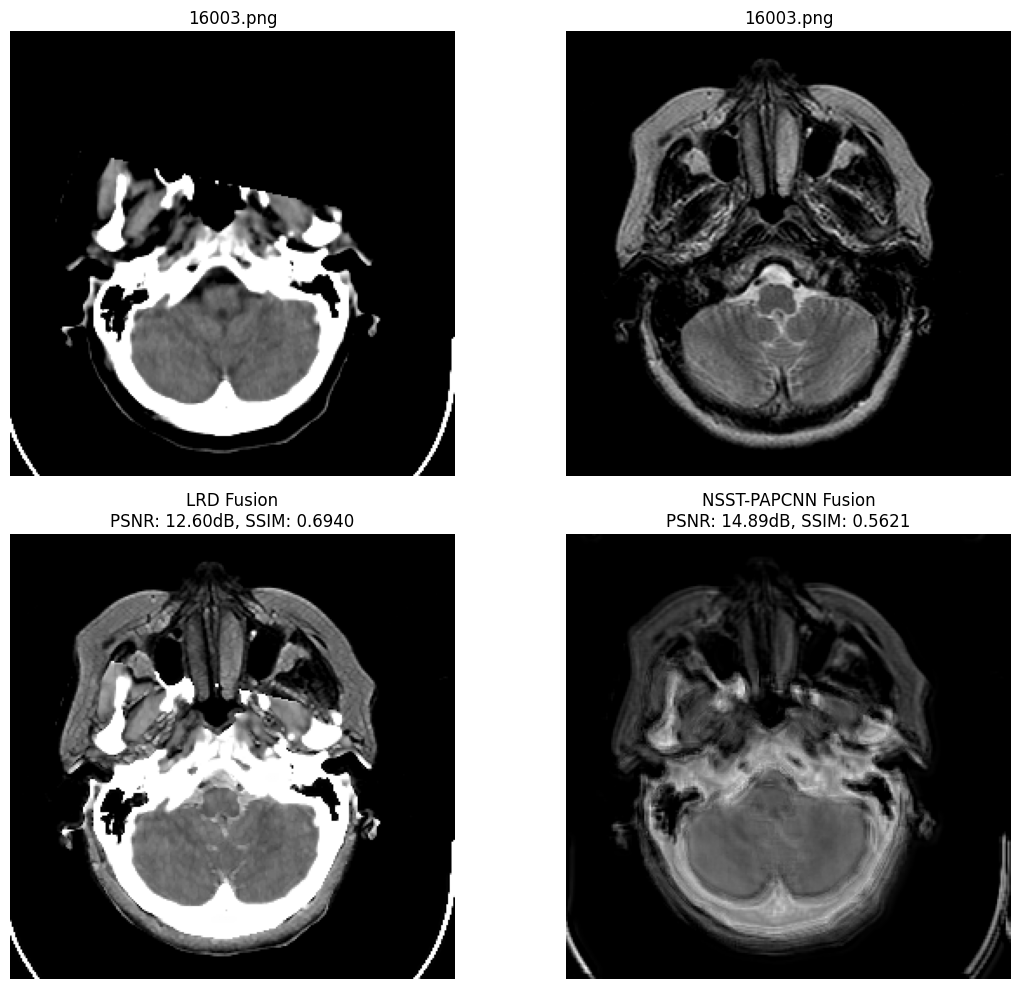

Comparison of fusion methods for 16003.png and 16003.png:
LRD Fusion - PSNR: 12.60 dB, SSIM: 0.6940
NSST-PAPCNN Fusion - PSNR: 14.89 dB, SSIM: 0.5621


In [24]:
# Import the LRD fusion function from our models module
from fusion_models import lrd_fusion

def custom_compare_models(img_path1, img_path2):
    """
    Custom compare fusion results from LRD and NSST-PAPCNN models
    
    Args:
        img_path1: Path to first source image
        img_path2: Path to second source image
    """
    # Load images
    img1, img2 = load_image_pair(img_path1, img_path2)
    
    # Get base filenames for finding saved fusion results
    img1_name = os.path.basename(img_path1).split('.')[0]
    img2_name = os.path.basename(img_path2).split('.')[0]
    
    # Generate fused images using both models
    fused_lrd = lrd_fusion(img1, img2, levels=4)
    fused_nsst = nsst_papcnn_fusion(img1, img2, levels=3, wavelet='db1')
    
    # Calculate metrics for both models
    metrics_lrd = fe.evaluate_fusion(fused_lrd, img1, img2)
    metrics_nsst = fe.evaluate_fusion(fused_nsst, img1, img2)
    
    # Create a figure with 4 subplots (2 rows, 2 columns)
    plt.figure(figsize=(12, 10))
    
    # Display source images
    plt.subplot(2, 2, 1)
    plt.imshow(img1, cmap='gray')
    plt.title(os.path.basename(img_path1))
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.imshow(img2, cmap='gray')
    plt.title(os.path.basename(img_path2))
    plt.axis('off')
    
    # Display fusion results
    plt.subplot(2, 2, 3)
    plt.imshow(fused_lrd, cmap='gray')
    plt.title(f"LRD Fusion\nPSNR: {metrics_lrd['psnr']:.2f}dB, SSIM: {metrics_lrd['ssim']:.4f}")
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.imshow(fused_nsst, cmap='gray')
    plt.title(f"NSST-PAPCNN Fusion\nPSNR: {metrics_nsst['psnr']:.2f}dB, SSIM: {metrics_nsst['ssim']:.4f}")
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('fused_images/comparison.png', dpi=300)
    plt.show()
    
    # Print comparison
    print(f"Comparison of fusion methods for {os.path.basename(img_path1)} and {os.path.basename(img_path2)}:")
    print(f"LRD Fusion - PSNR: {metrics_lrd['psnr']:.2f} dB, SSIM: {metrics_lrd['ssim']:.4f}")
    print(f"NSST-PAPCNN Fusion - PSNR: {metrics_nsst['psnr']:.2f} dB, SSIM: {metrics_nsst['ssim']:.4f}")
    
# Compare models for the first image pair
if image_pairs:
    img1_path, img2_path = image_pairs[0]
    custom_compare_models(img1_path, img2_path)

## Summary of Results

We have successfully applied the NSST-PAPCNN fusion method to the medical image pairs and saved the results to the `fused_images/NSST_PAPCNN/` folder. We've also compared the results with the LRD method to evaluate the performance of different approaches.

Here's what we've accomplished:
1. Set up a Python virtual environment for running image fusion models
2. Created a folder structure for organizing fused images from different models
3. Implemented the NSST-PAPCNN fusion method
4. Applied the fusion to multiple image pairs
5. Saved the results and calculated performance metrics
6. Compared results from different fusion models

The NSST-PAPCNN method provides a good balance between complexity and performance. It includes a neural network component (PCNN) but doesn't require training data, making it suitable for various applications.